Questions:
- how long is each window?
- background run for how long

In [1]:
import scipy.optimize
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

Defining some convenience plotting and file reading functions for now

In [53]:
def plot(adc_data, window_num=0, no_of_windows=1, cut_start=None, cut_end=None, show_output=True, window_length=1023):

    j = window_num                                              # Which window to pick out
    n = no_of_windows                                           # Number of windows to pick
    time = np.linspace(0, window_length*16*1e-3*n, window_length*n)               # How do we know the window is 16 milliseconds
    data = adc_data[j*window_length:(j+n)*window_length]

    # Is this number of entries per window * number of windows to study if we were talking continuous data ?

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)

    cut_time = []
    cut_data = []
    if cut_start and cut_end:
        for index, value in enumerate(time):
            if cut_start < value < cut_end:
                cut_time.append(value)
                cut_data.append(data[index])
        ax.plot(cut_time, cut_data, marker='.')

    else:
        ax.plot(time, data, marker='.')

    ax.set_xlabel('Time (arbitrary units)', fontsize=18, fontname='Times new Roman')
    ax.set_ylabel('ADC counts', fontsize=18, fontname='Times new Roman')
    plt.xticks(fontsize=15, fontname='Times new Roman')
    plt.xticks(fontsize=15, fontname='Times new Roman')
    plt.grid(True)

    if show_output:
        plt.show()
    else:
        return fig, ax

def read(file_name):
    with uproot.open(f'raw_data/{file_name}.root') as f:
        tree = f['T']                           # only one key in f object which is a mapping
        adc = tree["ADC"].array()
        adc = ak.flatten(adc)
        # adc = ak.flatten(adc)[:1023*100_000]    # Upto 100,000 windows of 1023 events each?

    return adc

Testing to see what the data from the digitizer looks like with the SiPM connected to it at 57V

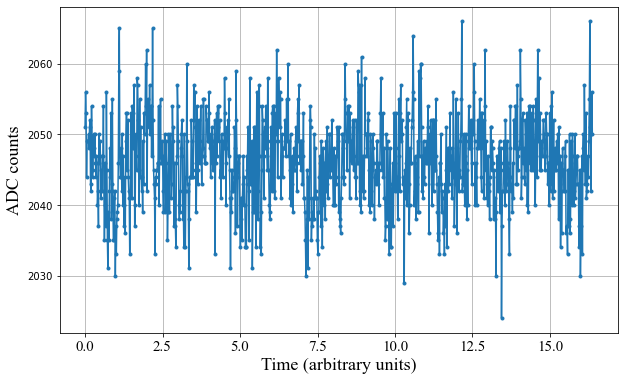

CPU times: total: 172 ms
Wall time: 156 ms


In [54]:
%%time

adc_data_trial = read('trial')
plot(adc_data_trial)

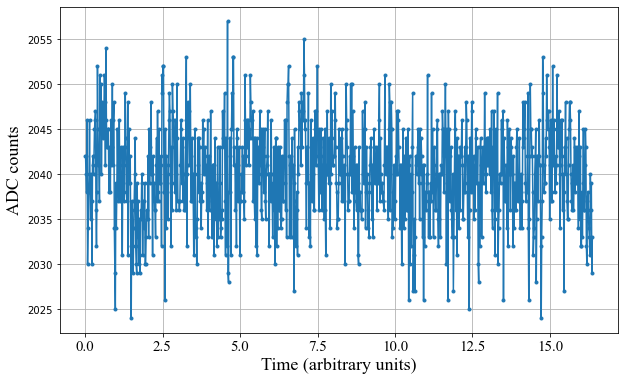

In [55]:
adc_data_noise_test_start = read('noise_test_start')
plot(adc_data_noise_test_start)

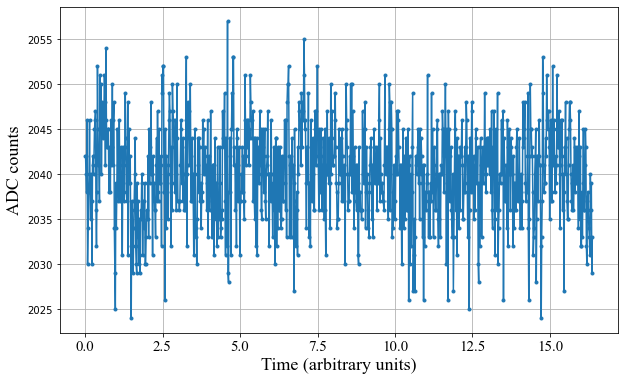

In [56]:
adc_data_noise_test_end = read('noise_test_start')
plot(adc_data_noise_test_end)

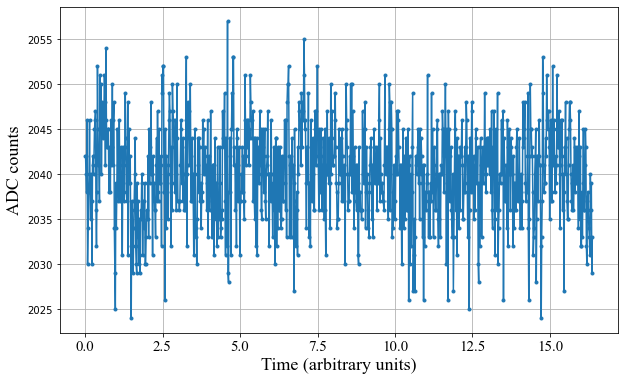

In [57]:
adc_data_run_test_start = read('noise_test_start')
plot(adc_data_run_test_start)

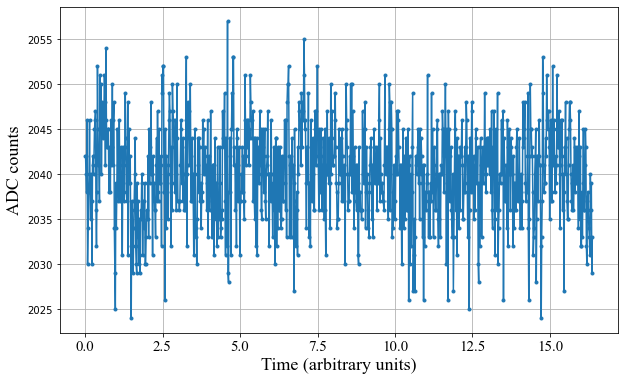

In [58]:
adc_data_run_test_middle = read('noise_test_start')
plot(adc_data_run_test_middle)

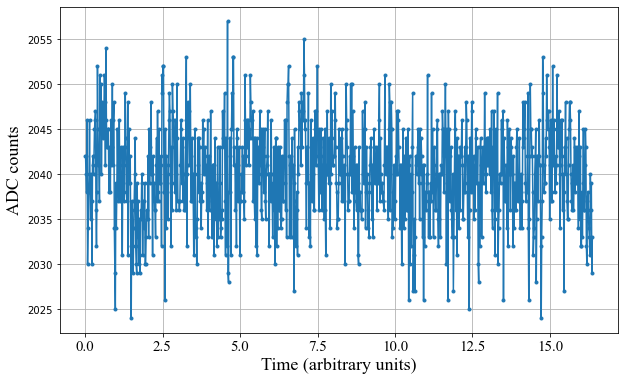

In [59]:
adc_data_run_test_end = read('noise_test_start')
plot(adc_data_run_test_end)

This change in the profile is most likely due to the SiPM heating up over time - over a period of roughly two hours

I think the SiPM behaviour was roughly stable for the first hour wich is more than enough time to collect any data I need - anymore and you collect too much data anyway

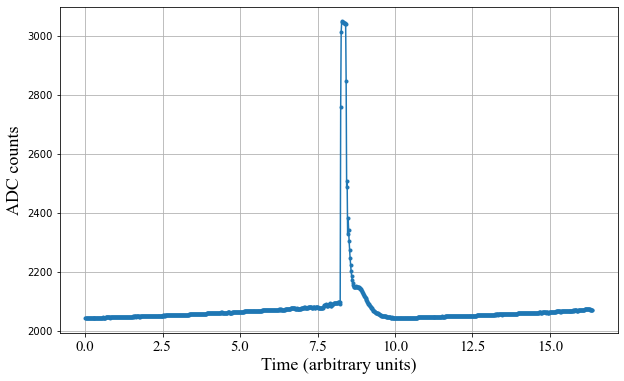

CPU times: total: 203 ms
Wall time: 201 ms


In [9]:
%%time

# %matplotlib notebook

adc_data_run2 = read('run2')
plot(adc_data_run2)

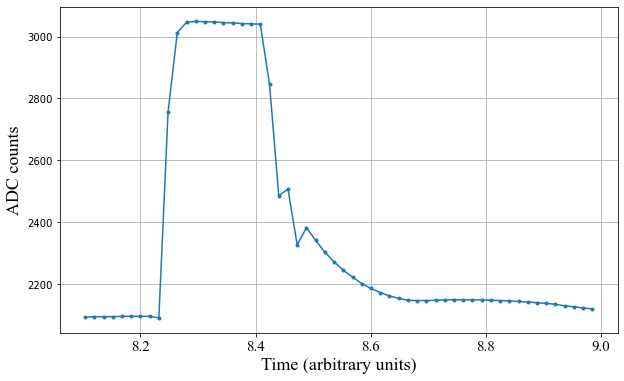

In [10]:
plot(adc_data_run2, 0, 1, 8.1, 9)

I will go with run2 for now (57 V) and see how many entries we have recorded

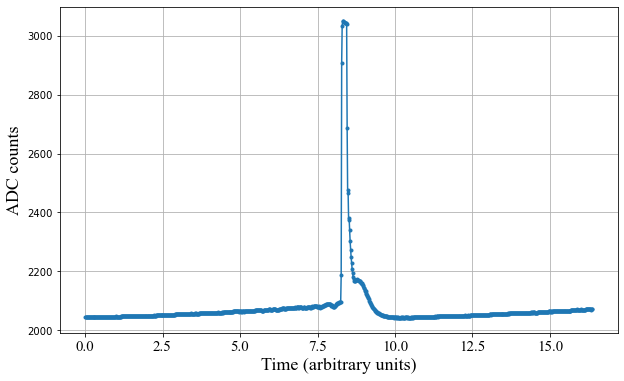

In [11]:
plot(adc_data_run2, 999, 1)

Signal seems to be fine at the end and at the beginning - need more than 1000 windows however

Signal seems to be clipping out at the top (saturating), will try lowering the voltage and the LED intensity to see if that helps at all

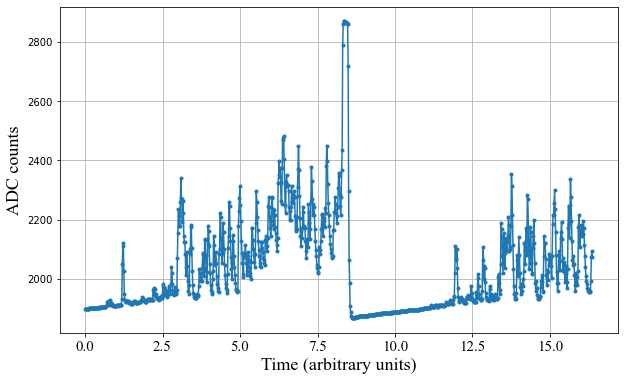

CPU times: total: 24.8 s
Wall time: 31 s


In [12]:
%%time

adc_data_trial1 = read('trial1.dat')
plot(adc_data_trial1, 100_000-1, 1)

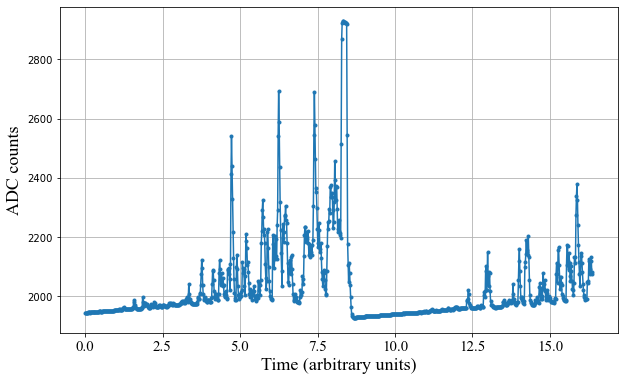

In [13]:
# %matplotlib notebook

plot(adc_data_trial1)

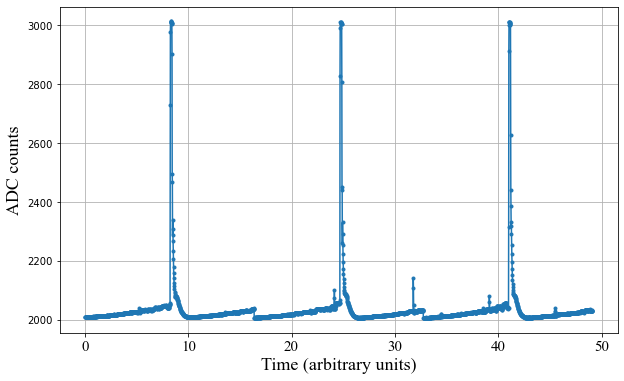

CPU times: total: 6.08 s
Wall time: 7.25 s


In [14]:
%%time

adc_data_trial_60V = read('trial_60V.dat')
plot(adc_data_trial_60V, 50_000, 3)

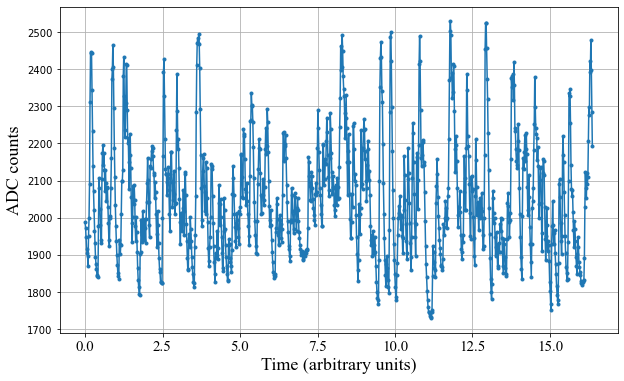

CPU times: total: 5.88 s
Wall time: 6.85 s


In [15]:
%%time

adc_data_bkg = read('bkg.dat')
plot(adc_data_bkg)

This is very noisy, probably more overheating

Ok so i was doing a lot wrong, namely the LED should not be turned up so high and i should be looking for single photoelectron peaks that would be somewhat mixed in with dark current - SEE WRITTEN NOTES

In [16]:
%%time

adc_data_run1_good = read('run1_good.dat')

CPU times: total: 24.4 s
Wall time: 31.6 s


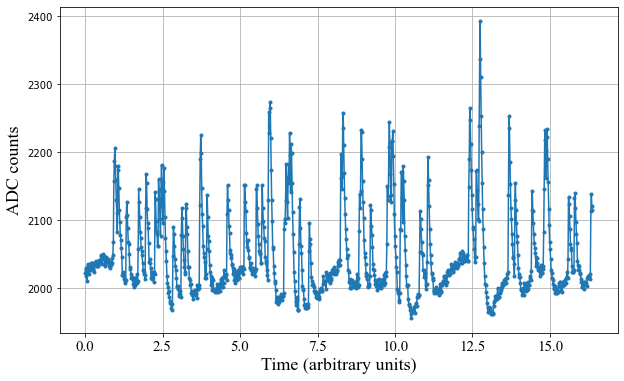

In [17]:
plot(adc_data_run1_good)

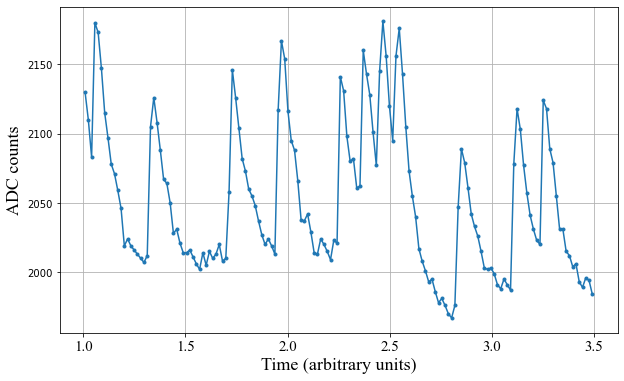

In [18]:
plot(adc_data_run1_good, 0, 1, 1, 3.5)

This is now a good plot that we can use! Now time to work out the coding

In [60]:
min_count = np.min(adc_data_run1_good)
good_data = adc_data_run1_good - min_count
plot(good_data)
plot(good_data, 0, 1, 1, 3.5)

NameError: name 'adc_data_run1_good' is not defined

Quick interlude - what is the average standard deviation of the background, maybe I can use that to somehow find a threshold for increase or decrease?

In [61]:
adc_data_noise_test = adc_data_noise_test_start + adc_data_noise_test_end
adc_data_noise_test_std = np.std(adc_data_noise_test)
print(adc_data_noise_test_std)

10.549318237874566


Peaks seem to go up smoothly but down somewhat jaggedly

What if i find the index of each peak, look 'back' and start integrating from the first time i get a higher value than the previous one. Then i would end integrating by either looking for two consecutive lower points compared to a reference point or if two successive points are lower than the previous one - could stop the integration at any of these points.

In [21]:
def find_pulse_areas_v1(sample_data, full_output=False):

    area = 0
    areas_list = []
    accending = False
    start_count = 0

    start_indices = []
    end_indices = []

    for i, count in enumerate(sample_data):

        if i == len(sample_data) - 2:
            break

        if accending:
            if sample_data[i+1] < count:
                accending = False
            else:
                area += count

        if area != 0 and not accending:

            if sample_data[i+1] > count and sample_data[i+2] > count and count - start_count < 3*adc_data_noise_test_std:
                if full_output:
                    end_indices.append(i)
                areas_list.append(area)
                area = 0
                start_count = 0
            else:
                area += count

        if area == 0 and (sample_data[i+1] - count > 50 or sample_data[i+2] - count > 50):
            if full_output:
                start_indices.append(i)
            area = count
            start_count = count
            accending = True

    if full_output:
        return areas_list, start_indices, end_indices
    else:
        return areas_list

Now does this look?? Should check this and make sure its working fine before moving on

In [22]:
%matplotlib notebook

test_sample = adc_data_run1_good[44400:45000]
test_areas_list, test_start_indices, test_end_indices = find_pulse_areas_v1(test_sample, full_output=True)

full_time = np.linspace(0, 1023*16*1e-3, 1023)
sample_time = full_time[:600]

figure = plt.figure(figsize=(9, 6))
axes = figure.add_subplot(111)
axes.plot(sample_time, test_sample, marker='.')

for start_index in test_start_indices:
    axes.axvline(sample_time[start_index], color='green', alpha=0.5)
for end_index in test_end_indices:
    axes.axvline(sample_time[end_index], color='red', alpha=0.5)

axes.set_xlabel('Time (arbitrary units)', fontsize=18, fontname='Times new Roman')
axes.set_ylabel('ADC counts', fontsize=18, fontname='Times new Roman')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>

For now this code counts overlapping pulses as one pulse. Changing it to count them as seperate pulses is a very quick change (removal of 3rd and in stopping if statement). Not sure if theres a way to completely remove them from my analysis - maybe using time constraints like a pulse shouldnt be longer than x us (maybe 0.3 us limit?)

overall 3 variations to trial - overlapping pulses as one pulse (current), as separate pulses (easy fix), ignoring them entirely (new code)

In [23]:
%%time

areas_list_run1_good_v1, start, end = find_pulse_areas_v1(adc_data_run1_good[:100000], full_output=True)

# Can't do all of it there's 102,300,000 datapoints...... (1023 * 100,000)

CPU times: total: 4.77 s
Wall time: 4.77 s


In [24]:
print(len(areas_list_run1_good_v1))
print(max(areas_list_run1_good_v1))
print(np.argwhere(areas_list_run1_good_v1 == np.max(areas_list_run1_good_v1))[0])
print(start[np.argwhere(areas_list_run1_good_v1 == np.max(areas_list_run1_good_v1))[0][0]])
print(areas_list_run1_good_v1)

3267
3031151
[1455]
44434
[52395, 34768, 30889, 26976, 74658, 30333, 20506, 26577, 31317, 38598, 28975, 14682, 24887, 26899, 41920, 54843, 32379, 38265, 46240, 43814, 32638, 54924, 31364, 30611, 28973, 31919, 57001, 29495, 32782, 22802, 54351, 20718, 36908, 50427, 47965, 30693, 33663, 16700, 41298, 34777, 22573, 28791, 37760, 32747, 33161, 27012, 35299, 59762, 18665, 37196, 41275, 36432, 52423, 32108, 42644, 37186, 35251, 33418, 51701, 39948, 41882, 24821, 65000, 20572, 28514, 22196, 32453, 37336, 53986, 35698, 16625, 29389, 20556, 22554, 22556, 35844, 24822, 33366, 33334, 61274, 33712, 30830, 31284, 31128, 23060, 16887, 14749, 26956, 39037, 51510, 61098, 26375, 10338, 29079, 33155, 43851, 41897, 24822, 20767, 37381, 28645, 28816, 38040, 30724, 31903, 20631, 24619, 22610, 36058, 20702, 23203, 22844, 26395, 22591, 16645, 30988, 28759, 16608, 32799, 41375, 27143, 27103, 51253, 35024, 37599, 16688, 24741, 38725, 30747, 45592, 36853, 68118, 39479, 18869, 41795, 39262, 48678, 25317, 33008, 

Not sure why some of these values are far too high, for now im going to try and ignore them and work with the rest

In [25]:
areas_list_run1_good_v1 = np.array(areas_list_run1_good_v1)
areas_list_run1_good_v1 = np.where(areas_list_run1_good_v1 < 100_000, areas_list_run1_good_v1, 100_000)

figure = plt.figure()
axes = figure.add_subplot(111)

axes.hist(areas_list_run1_good_v1, bins=1000)

plt.show()

<IPython.core.display.Javascript object>

Now to try with including overlapping peaks as seperate

In [26]:
def find_pulse_areas_v2(sample_data, full_output=False):

    area = 0
    areas_list = []
    accending = False

    start_indices = []
    end_indices = []

    for i, count in enumerate(sample_data):

        if i == len(sample_data) - 2:
            break

        if accending:
            if sample_data[i+1] < count:
                accending = False
            else:
                area += count

        if area != 0 and not accending:

            if sample_data[i+1] > count and sample_data[i+2] > count:
                if full_output:
                    end_indices.append(i)
                areas_list.append(area)
                area = 0
            else:
                area += count

        if area == 0 and (sample_data[i+1] - count > 50 or sample_data[i+2] - count > 50):
            if full_output:
                start_indices.append(i)
            area = count
            accending = True

    if full_output:
        return areas_list, start_indices, end_indices
    else:
        return areas_list

In [27]:
areas_list_run1_good_v2 = find_pulse_areas_v2(adc_data_run1_good[:100000])

In [28]:
print(len(areas_list_run1_good_v2))
print(max(areas_list_run1_good_v2))
print(np.argwhere(areas_list_run1_good_v2 == np.max(areas_list_run1_good_v2))[0])
print(areas_list_run1_good_v2)

4546
57859
[1287]
[19245, 33150, 34768, 30889, 26976, 14576, 12655, 10679, 36748, 30333, 20506, 26577, 31317, 38598, 28975, 14682, 24887, 26899, 6400, 8170, 10696, 6439, 6581, 22957, 32379, 38265, 10599, 35641, 8241, 35573, 32638, 6239, 15233, 33452, 6059, 8559, 16746, 30611, 28973, 31919, 14799, 42202, 29495, 32782, 22802, 14939, 39412, 20718, 36908, 16733, 33694, 20592, 27373, 30693, 10491, 23172, 16700, 12396, 28902, 34777, 22573, 28791, 37760, 32747, 33161, 27012, 35299, 10454, 49308, 18665, 37196, 41275, 13046, 23386, 15153, 37270, 32108, 13093, 29551, 10413, 26773, 12376, 22875, 33418, 23141, 28560, 39948, 41882, 24821, 8344, 13441, 43215, 20572, 28514, 22196, 32453, 37336, 16771, 37215, 35698, 16625, 6244, 23145, 20556, 22554, 22556, 35844, 24822, 33366, 33334, 8369, 6672, 33039, 33712, 30830, 31284, 31128, 23060, 16887, 14749, 26956, 39037, 51510, 8528, 20021, 32549, 26375, 10338, 29079, 33155, 10471, 33380, 10475, 31422, 24822, 20767, 37381, 28645, 28816, 38040, 30724, 31903, 

In [29]:
areas_list_run1_good_v2 = np.array(areas_list_run1_good_v2)
areas_list_run1_good_v2 = np.where(areas_list_run1_good_v2 < 100_000, areas_list_run1_good_v2, 100_000)

figure = plt.figure()
axes = figure.add_subplot(111)

axes.hist(areas_list_run1_good_v2, bins=1000)

plt.show()

<IPython.core.display.Javascript object>

Now try version 3 where we ignore multiple overlapping pules entirely

In [30]:
# finding how many indices are in ~0.3 us

tmep_count = 0
for trial_time in full_time:
    if trial_time > 0.3:
        break
    tmep_count += 1

print(tmep_count)

19


In [31]:
def find_pulse_areas_v3(sample_data, full_output=False):

    area = 0
    areas_list = []
    accending = False
    start_count = 0
    start_i = 0
    start_indices = []
    end_indices = []

    for i, count in enumerate(sample_data):

        if i == len(sample_data) - 2:
            break

        if accending:
            if sample_data[i+1] < count:
                accending = False
            else:
                area += count

        if area != 0 and not accending:

            if sample_data[i+1] > count and sample_data[i+2] > count and count - start_count < 3*adc_data_noise_test_std:

                if i - start_i < 20:
                    areas_list.append(area)
                    if full_output:
                        end_indices.append(i)

                area = 0
                start_count = 0
            else:
                area += count

        if area == 0 and (sample_data[i+1] - count > 3*adc_data_noise_test_std or sample_data[i+2] - count > 3*adc_data_noise_test_std):
            if full_output:
                start_indices.append(i)
            area = count
            start_count = count
            start_i = i
            accending = True

    if full_output:
        return areas_list, start_indices, end_indices
    else:
        return areas_list

In [32]:
%matplotlib notebook

test_sample = adc_data_run1_good[:200]
test_areas_list, test_start_indices, test_end_indices = find_pulse_areas_v3(test_sample, full_output=True)

full_time = np.linspace(0, 1023*16*1e-3*2, 1023*2)
sample_time = full_time[:200]

figure = plt.figure(figsize=(8, 6))
axes = figure.add_subplot(111)
axes.plot(sample_time, test_sample, marker='.')

for start_index in test_start_indices:
    axes.axvline(sample_time[start_index], color='green', alpha=0.5)
for end_index in test_end_indices:
    axes.axvline(sample_time[end_index], color='red', alpha=0.5)

axes.set_xlabel('Time (arbitrary units)', fontsize=18, fontname='Times new Roman')
axes.set_ylabel('ADC counts', fontsize=18, fontname='Times new Roman')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>

seems to be working as i want it to, im going to try to plot the histogram now

In [33]:
%%time

areas_list_run1_good_v3 = find_pulse_areas_v3(adc_data_run1_good[:10_000_000])

CPU times: total: 7min 54s
Wall time: 7min 54s


In [34]:
print(len(areas_list_run1_good_v3))
print(max(areas_list_run1_good_v3))
print(np.argwhere(areas_list_run1_good_v3 == np.max(areas_list_run1_good_v3))[0])
# print(areas_list_run1_good_v3)

242056
42979
[42218]


In [35]:
areas_list_run1_good_v3 = np.array(areas_list_run1_good_v3)
areas_list_run1_good_v3 = np.where(areas_list_run1_good_v3 < 100_000, areas_list_run1_good_v3, 100_000)

figure = plt.figure()
axes = figure.add_subplot(111)

axes.hist(areas_list_run1_good_v3, bins=1000)

plt.show()

<IPython.core.display.Javascript object>

Lets try another version built ontop of version 3 that only records the pulse area and somewhat crudely removes the 'background area'

In [36]:
def find_pulse_areas_v4(sample_data, full_output=False):

    area = 0
    areas_list = []
    accending = False
    start_count = 0
    start_i = 0
    start_indices = []
    end_indices = []
    removed_areas = []

    for i, count in enumerate(sample_data):

        if i == len(sample_data) - 2:                       # to prevent problems at the end of the list
            break

        if accending:
            if sample_data[i+1] < count:
                accending = False
            else:
                area += count

        if area != 0 and not accending:                     # stopping check

            if sample_data[i+1] > count and sample_data[i+2] > count and count - start_count < 25:      # stopping condition

                if i - start_i < 20:                        # if the pulse isn't too wide (only one pulse not multiple)

                    if count > start_count:                 # remove the area underneath the curve
                        remove_area = start_count * (i - start_i) + (count - start_count) * (i - start_i) * 0.5
                    elif count < start_count:
                        remove_area = count * (i - start_i) + (start_count - count) * (i - start_i) * 0.5
                    else:
                        remove_area = start_count * (i - start_i)

                    removed_areas.append(remove_area)

                    areas_list.append(area - remove_area)
                    if full_output:
                        end_indices.append(i)

                area = 0
                start_count = 0
            else:                                           # if stopping check not met keep counting
                area += count

        if area == 0 and (sample_data[i+1] - count > 50 or sample_data[i+2] - count > 50):
            if full_output:
                start_indices.append(i)
            area = count
            start_count = count
            start_i = i
            accending = True

    if full_output:
        return areas_list, start_indices, end_indices, removed_areas

    return areas_list

# All the numbers put in here are estimates - I am aware this isnt robust and there will be / are errors, i've tried to minimize them as much as possible but idk how to do anymore
# I have other ideas but none of them work since the background itself varies soo much its hard to set any meaningful thresholds

In [37]:
areas_list_run1_good_v4, _, _, test_removed_areas = find_pulse_areas_v4(adc_data_run1_good[:10_000_000], full_output=True)

In [38]:
print(len(areas_list_run1_good_v4))
print(max(areas_list_run1_good_v4))
print(np.argwhere(areas_list_run1_good_v4 == np.max(areas_list_run1_good_v4))[0])
print(areas_list_run1_good_v4)

192326
5226.5
[50607]
[691.5, 716.5, 807, 670.5, 1212.0, 522.0, 695.0, 707.0, 563.0, 587.0, 875.0, 635.5, 614.0, 1491.5, 708.5, 980.0, 1341.5, 1229.0, 726.0, 565.5, 528.0, 674.0, 723.0, 1199.0, 452.0, 947.0, 534.5, 679.0, 1346, 523.0, 689.0, 609.0, 823.0, 814.5, 692.0, 2041.0, 748.0, 1240.0, 1183.0, 1610.0, 1520.5, 587.0, 522.0, 836.0, 656.0, 645.0, 1381.0, 1358.0, 405.0, 1004.0, 416.0, 554.0, 616.5, 1368.0, 588.0, 742.0, 702.0, 1424.0, 605, 849.0, 738.0, 515.5, 447.0, 350.0, 566.0, 790.0, 1010.0, 603.0, 675.0, 570.0, 482.0, 1282.0, 666.0, 746.0, 1581.0, 641.5, 1445.5, 436.0, 1633.0, 487.0, 966.5, 684.5, 609.5, 530.5, 619, 456.0, 583.0, 603.5, 680.5, 1109.0, 1194.0, 452.0, 549.0, 725.0, 717, 817.0, 975.5, 1338.0, 747.0, 552.0, 1145.0, 675.0, 1408.0, 475.0, 530.0, 579.0, 411.5, 1371.0, 578.0, 512.0, 1202.5, 1410.0, 1248.0, 829.5, 1327.5, 584.0, 1169.5, 643.5, 611.0, 895.5, 719.5, 641.0, 570.0, 779.5, 1383.0, 593.0, 1754.0, 568.0, 1253.0, 435.0, 556.5, 746.0, 742.0, 602.0, 1128.5, 534.0,

In [39]:
areas_list_run1_good_v4 = np.array(areas_list_run1_good_v4)
areas_list_run1_good_v4 = np.where(areas_list_run1_good_v4 < 100_000, areas_list_run1_good_v4, 100_000)

figure = plt.figure()
axes = figure.add_subplot(111)
temp = axes.hist(areas_list_run1_good_v4, bins=1000)
plt.show()

areas_list_run1_good_v4_bins = temp[0]
areas_list_run1_good_v4_adc = temp[1]
areas_list_run1_good_v4_adc = (areas_list_run1_good_v4_adc[1:] + areas_list_run1_good_v4_adc[:-1]) / 2
areas_list_run1_good_v4_bin_errs = np.sqrt(areas_list_run1_good_v4_bins)
areas_list_run1_good_v4_bin_errs = np.where(areas_list_run1_good_v4_bin_errs == 0, np.inf, areas_list_run1_good_v4_bin_errs)

<IPython.core.display.Javascript object>

lets have a look at a plot of what i removed to see if that gives any insight into why this plot is so different from the last

In [40]:
figure = plt.figure()
axes = figure.add_subplot(111)
temp = axes.hist(test_removed_areas, bins=1000)
plt.show()

<IPython.core.display.Javascript object>

In [41]:
print(areas_list_run1_good_v4_bins)
print()
print(areas_list_run1_good_v4_bin_errs)
print()
print(areas_list_run1_good_v4_adc)

[1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 2.000e+00 3.000e+00 2.000e+00
 8.000e+00 4.000e+00 7.000e+00 5.000e+00 4.000e+00 1.000e+01 1.000e+01
 9.000e+00 6.000e+00 5.000e+00 7.000e+00 9.000e+00 4.000e+00 1.000e+01
 1.500e+01 1.200e+01 1.600e+01 1.300e+01 1.900e+01 1.100e+01 2.100e+01
 2.000e+01 2.400e+01 2.400e+01 2.400e+01 1.500e+01 2.000e+01 2.000e+01
 4.000e+01 3.600e+01 2.700e+01 3.500e+01 5.400e+01 3.900e+01 4.400e+01
 4.200e+01 6.500e+01 3.600e+01 4.500e+01 7.000e+01 6.800e+01 6.400e+01
 8.500e+01 7.800e+01 9.300e+01 1.160e+02 1.190e+02 1.150e+02 1.160e+02
 1.580e+02 1.680e+02 1.530e+02 1.970e+02 1.870e+02 1.900e+02 2.300e+02
 2.700e+02 2.560e+02 2.790e+02 3.030e+02 3.460e+02 3.350e+02 4.230e+02
 3.710e+02 5.070e+02 5.420e+02 5.020e+02 5.560e+02 5.990e+02 6.860e+02
 7.860

Might remove the points before and after that have zeros so that the code later can work properly (no divide by zero errors)

could also try to do all this after 'zeroing' all the data but should just change raw values not the overall shape of the finger plot since you are just removing a common 'chunk' that is included in all area analysis??

1) treat multiple overlapping pulses as one pulse
2) treat multiple overlapping separate pulses
3) ignore them entirely
4) cut off the 'bottom' of pulses
5) why not use pulse height - is it cause of the variable background?

Ok so apparently point 4 is correct, the reason why I was seeing so many peaks before was cause of the background being so varied, i was effectively shifting everything up and down - we don't know why it was such a nice spread though and why its so uniform ??

As far as gain curve goes, pedestal + 3 peaks is good - avoids problems with non-linearities so the fitting gets much easier

Should try to take some data from the scope next since I know exactly what time window to integrate in and it should give cleaner peaks

As far as peak height goes - ya do that as well but ofcourse it only works if the background is consistent which its not here

What do I see from the oscilloscope - not sure this is the right data

In [42]:
osci_data_test1_full = np.genfromtxt('raw_data/test1.csv', delimiter=',', skip_header=2)
osci_data_test1_time = osci_data_test1_full[:, 0][:19990]
osci_data_test1_ch1 = osci_data_test1_full[:, 1][:19990]
osci_data_test1_ch2 = osci_data_test1_full[:, 2][:19990]

In [43]:
figure = plt.figure()
axes = figure.add_subplot(111)
axes.plot(osci_data_test1_time, osci_data_test1_ch1)
axes.plot(osci_data_test1_time, osci_data_test1_ch2)
plt.show()

<IPython.core.display.Javascript object>

Ignoring if what ive done so far is correct or not, what options do i have for actually making the gain curve

In [44]:
figure = plt.figure()
axes = figure.add_subplot(111)
axes.plot(areas_list_run1_good_v4_adc, areas_list_run1_good_v4_bins)
plt.show()

<IPython.core.display.Javascript object>

$$ \mu_i = \mu_0 + iG $$
$$ \sigma_i = \sqrt{\sigma_0^2 + ia} $$
$$ T = \sum_{i=0}^{N-1} n_i Y(\mu_i, \sigma_i^2) $$

In [45]:
def gaussian(adc_count, norm, avg, std):
    return norm * np.exp(-(adc_count - avg) ** 2 / (2 * std ** 2))

def model_gaussian_sum(adc_count, parameters):

    # guesses : [[G, a], [norm_0, mean_0, std_0], [norn_1, norm_2, ..., norm_(N-1)]]

    guesses = [[parameters[0], parameters[1]], [parameters[2], parameters[3], parameters[4]], parameters[5:]]

    G = guesses[0][0]
    a = guesses[0][1]
    mu_0 = guesses[1][1]
    std_0 = guesses[1][2]

    model = gaussian(adc_count, guesses[1][0], mu_0, std_0)

    for i in range(1, len(guesses[2]) + 1):
        model += gaussian(adc_count, guesses[2][i-1], mu_0 + i*G, np.sqrt(std_0**2 + i*a))

    return model

def chi_squared_function_sum(parameters, hist_count, adc_count, hist_count_errs, min_val=None):

    if min_val:
        return np.abs(np.sum((model_gaussian_sum(adc_count, parameters) - hist_count)**2 / hist_count_errs**2) - (min_val + 1))
    else:
        return np.sum((model_gaussian_sum(adc_count, parameters) - hist_count)**2 / hist_count_errs**2)


In [46]:
areas_list_run1_good_v4_fit_params_sum = scipy.optimize.minimize(chi_squared_function_sum, np.array([1000, 10, 300, 600, 80, 500, 50]),
    args=(areas_list_run1_good_v4_bins, areas_list_run1_good_v4_adc, areas_list_run1_good_v4_bin_errs),
    bounds=((100, 2000), (0.00001, None), (None, None), (0, 1000), (1, 500), (None, None), (None, None))).x

# test = [700, 6.17988244, 200, 609.62364119, 80, 30]
areas_list_run1_good_v4_pred_sum = model_gaussian_sum(areas_list_run1_good_v4_adc, areas_list_run1_good_v4_fit_params_sum)

figure = plt.figure(figsize=(10, 8))
axes = figure.add_subplot(111)
axes.plot(areas_list_run1_good_v4_adc, areas_list_run1_good_v4_bins, color='#1f77b4')
axes.plot(areas_list_run1_good_v4_adc, areas_list_run1_good_v4_pred_sum, color='red')
plt.show()

<IPython.core.display.Javascript object>

Seems like the norm is the height of the peak - makes sense since gaussians are normalised to 1

In [47]:
print(areas_list_run1_good_v4_fit_params_sum)

[  616.34996234 28272.41437868  2705.71942398   611.62434351
   107.90806186   425.62110632    73.42184358]


I want to find the error on the 'mean' fit value (dont really care much for the rest) which in this case is the gain value (2nd entry or index 1)

In [48]:
chi_squared_range = []
gain = areas_list_run1_good_v4_fit_params_sum[0]
g_testing_range = np.linspace(500, 700, 1000)

for g_test in g_testing_range:
    chi_squared = chi_squared_function_sum(np.append(g_test, areas_list_run1_good_v4_fit_params_sum[1:]), areas_list_run1_good_v4_bins,
                                           areas_list_run1_good_v4_adc, areas_list_run1_good_v4_bin_errs)
    chi_squared_range.append(chi_squared)

min_index = np.argmin(chi_squared_range)
chi_squared_min = chi_squared_range[min_index]
g_best = g_testing_range[min_index]

print(min_index)

g_std_index_lower = np.argmin(np.abs(chi_squared_range[:min_index] - (chi_squared_min + 1)))
g_std_index_upper = np.argmin(np.abs(chi_squared_range[min_index:] - (chi_squared_min + 1))) + min_index

g_best_std = 0.5 * (np.abs(g_best - g_testing_range[g_std_index_lower]) + np.abs(g_best - g_testing_range[g_std_index_upper]))

print(g_best)
print(g_best_std)

581
616.3163163163163
1.2012012012011724


This doesn't work since I should be optimising for the rest of the parameters seperately given a set value of g but here I am just finding the chi-squared using the optimum value for the other parameters! Im not even sure how id do this so for now Im only going to use the 'one bound' method.

In [49]:
chi_squared_min_sum = chi_squared_function_sum(areas_list_run1_good_v4_fit_params_sum, areas_list_run1_good_v4_bins,
                                               areas_list_run1_good_v4_adc, areas_list_run1_good_v4_bin_errs)

test_bound_sum = scipy.optimize.minimize(chi_squared_function_sum, np.array([1000, 10, 200, 600, 80, 30, 5]),
    args=(areas_list_run1_good_v4_bins, areas_list_run1_good_v4_adc, areas_list_run1_good_v4_bin_errs, chi_squared_min_sum),
    bounds=((100, 2000), (0.00001, None), (None, None), (0, 1000), (1, 500), (None, None), (None, None))).x
print(test_bound_sum)

[  616.5068656  28751.59295519  2706.75672619   611.63105912
   107.84284173   423.46332236    72.93863423]


In [50]:
print(6.10326827e+02 - 6.10321865e+02)

0.0049619999999777065


Maybe this is not how this works, to find the error on the gain you have to make sure that is the only parameter you vary explicitly and fit for the rest each time ? - YES, what i have done is not statistically sound  (idk why though, maybe something in 240 notes)

What if i just used curve-fit

In [51]:
def model_gaussian_sum_v2(adc_count, *parameters):

    # guesses : [[G, a], [norm_0, mean_0, std_0], [norn_1, norm_2, ..., norm_(N-1)]]

    guesses = [[parameters[0], parameters[1]], [parameters[2], parameters[3], parameters[4]], parameters[5:]]

    G = guesses[0][0]
    a = guesses[0][1]
    mu_0 = guesses[1][1]
    std_0 = guesses[1][2]

    model = gaussian(adc_count, guesses[1][0], mu_0, std_0)

    for i in range(1, len(guesses[2]) + 1):
        model += gaussian(adc_count, guesses[2][i-1], mu_0 + i*G, np.sqrt(std_0**2 + i*a))

    return model

popt, pcov = scipy.optimize.curve_fit(model_gaussian_sum_v2, areas_list_run1_good_v4_adc, areas_list_run1_good_v4_bins,
                                      p0=np.array([1000, 10, 200, 600, 80, 30, 5]), sigma=areas_list_run1_good_v4_bin_errs)
print(popt)
print(np.sqrt(np.diag(pcov)))

[4.97747133e+02 1.14888817e+05 2.69481492e+03 6.06588669e+02
 9.91280994e+01 2.85302970e+02 5.15454568e+01]
[1.24908350e+01 5.11113738e+03 2.57248053e+01 8.29816425e-01
 7.44669107e-01 6.43169614e+00 7.48334719e+00]


In [52]:
print(areas_list_run1_good_v4_fit_params_sum)

[  616.34996234 28272.41437868  2705.71942398   611.62434351
   107.90806186   425.62110632    73.42184358]


Seems like I get the same (basically the same) results from curve-fit with some errors that seem somewhat reasonable - issue is that I can't vary the number of parameters so the code can't be generalised to work with N peaks that need some fitting :( - maybe there is an object oriented programming way or a recursive way to fix this or something with lambda, or maybe i just have to do errors manually

Very easily fixed but letting the input be variable with *args (completely forgot this was thing) - this does requite p0 to be given as that is what curvefit uses to determine the number of parameters being used in the fitting!

I still want to try and see if i can reproduce these errors the 'proper' way from ucsb phys 240 (shame this is a non-linear fir with poisson errors otherwirse i could have used other 'robust' methods to find the error ) - right now i need to use either $\chi^2 + 1$ method or bootstrap resampling maybe?

From my testing with the code from the 240 assignment, looks like the best idea is to find a way to make the chi-squared list things work! Basically for every trial of G in my list, i need to optimise for the rest of the parameters and then find the chi_squared (not use their optimal values for the chi-squared directly)

Given a value of G from an outer loop, i need to find the optimal value for the other parameters, then find the chi-squared, store that in another list and then use that to find out optimal G value and the error on it using the plus minus one method from the chi squared list (all to do with proper matching of indices)

In [53]:
def chi_squared_function_sum_v2(parameters_partial, hist_count, adc_count, hist_count_errs, G_trial):

    # parameters : [[G, a], [norm_0, mean_0, std_0], [norn_1, norm_2, ..., norm_(N-1)]]

    parameters = np.append(G_trial, parameters_partial)

    return np.sum((model_gaussian_sum(adc_count, parameters) - hist_count)**2 / hist_count_errs**2)

In [54]:
%%time

chi_squared_range = []
g_testing_range = np.linspace(600, 620, 500)

for g_test in g_testing_range:
    fit_params_sum_test = scipy.optimize.minimize(chi_squared_function_sum_v2, np.array([10, 200, 600, 80, 30, 5]),
        args=(areas_list_run1_good_v4_bins, areas_list_run1_good_v4_adc, areas_list_run1_good_v4_bin_errs, g_test),
        bounds=((0.00001, None), (None, None), (0, 1000), (1, 500), (None, None), (None, None))).x
    chi_squared = chi_squared_function_sum_v2(fit_params_sum_test, areas_list_run1_good_v4_bins, areas_list_run1_good_v4_adc,
                                              areas_list_run1_good_v4_bin_errs, g_test)
    chi_squared_range.append(chi_squared)

min_index = np.argmin(chi_squared_range)
chi_squared_min = chi_squared_range[min_index]
g_best = g_testing_range[min_index]

print(min_index)
print(chi_squared_min)

g_std_index_lower = np.argmin(np.abs(chi_squared_range[:min_index] - (chi_squared_min + 1)))
g_std_index_upper = np.argmin(np.abs(chi_squared_range[min_index:] - (chi_squared_min + 1))) + min_index

g_best_std = 0.5 * (np.abs(g_best - g_testing_range[g_std_index_lower]) + np.abs(g_best - g_testing_range[g_std_index_upper]))

print(g_best)
print(g_best_std)

408
5095.794203721491
616.3527054108216
1.5030060120240591
CPU times: total: 23.3 s
Wall time: 23.4 s


Yayyy!! This seems to give the best estimate on the error

REMEMBER - this isnt the 'true' error since i havnt accouted for the error in the pulse integral calculation but i guess that is kinda taken care of in the poisson error of the histograms, basically this is a sortof lower bound.

What if i run them as independent gaussians instead?

In [55]:
def linear_model(x_variable, parameters):

    return parameters[0] * x_variable + parameters[1]

def linear_fit(x_data, y_data, y_uncertainties):

    weights = 1. / y_uncertainties**2
    repeated_term = (np.sum(weights) * np.sum(x_data**2 * weights)
                     - np.sum(x_data * weights)**2)
    slope = ((np.sum(weights) * np.sum(x_data * y_data * weights)
              - np.sum(x_data * weights) * np.sum(y_data * weights))
             / repeated_term)
    slope_uncertainty = np.sqrt(np.sum(weights) / repeated_term)
    offset = ((np.sum(y_data * weights) * np.sum(x_data**2 * weights)
               - np.sum(x_data * weights) * np.sum(x_data * y_data * weights))
              / repeated_term)
    offset_uncertainty = np.sqrt(np.sum(x_data**2 * weights) / repeated_term)

    return (np.array([slope, offset]), np.array([slope_uncertainty,
                                                 offset_uncertainty]))

I am going to need two different functions i think, one for the errors and one for the minimisation since they have slightly different arguments - remember that here since we are trying to find the error on the 'mean' and not the 'gain' directly itll be a little different

In [56]:
def chi_squared_function_indep(parameters, hist_count, adc_count, hist_count_errs):

    return np.sum((gaussian(adc_count, parameters[0], parameters[1], parameters[2]) - hist_count)**2 / hist_count_errs**2)

def chi_squared_function_indep_v2(parameters_partial, hist_count, adc_count, hist_count_errs, mean_trial):

    parameters = [parameters_partial[0], mean_trial, parameters_partial[1]]

    return np.sum((gaussian(adc_count, parameters[0], parameters[1], parameters[2]) - hist_count)**2 / hist_count_errs**2)

def indep_gaussian_fit(guesses, hist_count, adc_count, hist_count_errs, make_plot=False):

    # guesses = [[norm_0, mean_0, std_0, lower_lim_0, upper_lim_0], [norm_1, mean_1, std_1, lower_lim_1, upper_lim_1], ....]

    best_params_all = np.empty((0, 3))
    best_mean_errs_all = np.array([])

    if make_plot:
        fig = plt.figure(figsize=(10, 5))
        ax1 = fig.add_subplot(121)
        ax1.plot(areas_list_run1_good_v4_adc, areas_list_run1_good_v4_bins)

    for guess in guesses:

        fitting_indices = [(adc_count <= guess[4]) * (adc_count >= guess[3])][0]

        fitting_adc_counts = adc_count[fitting_indices]
        fitting_bins = hist_count[fitting_indices]
        fitting_bin_errs = hist_count_errs[fitting_indices]

        # find starting and ending indices to cut the rest of the data as well

        best_params = scipy.optimize.minimize(chi_squared_function_indep, np.array(guess[:3]),
                                              args=(fitting_bins, fitting_adc_counts, fitting_bin_errs)).x
        best_params_all = np.vstack((best_params_all, best_params))

        mean_best = best_params[1]
        chi_squared_testing_range = []
        mean_testing_range = np.linspace(mean_best-mean_best/100, mean_best+mean_best/100, 1000)

        for mean_test in mean_testing_range:
            fit_params_indep_test = scipy.optimize.minimize(chi_squared_function_indep_v2, np.array([guess[0], guess[2]]),
                                              args=(fitting_bins, fitting_adc_counts, fitting_bin_errs, mean_test)).x
            chi_squared_test = chi_squared_function_indep_v2(fit_params_indep_test, fitting_bins,
                                                             fitting_adc_counts, fitting_bin_errs, mean_test)
            chi_squared_testing_range.append(chi_squared_test)

        min_index_indep = np.argmin(chi_squared_testing_range)
        chi_squared_min_indep = chi_squared_testing_range[min_index_indep]

        mean_std_index_lower = np.argmin(np.abs(chi_squared_testing_range[:min_index_indep] - (chi_squared_min_indep + 1)))
        mean_std_index_upper = np.argmin(np.abs(chi_squared_testing_range[min_index_indep:] - (chi_squared_min_indep + 1))) + min_index_indep

        mean_best_std = 0.5 * (np.abs(mean_best - mean_testing_range[mean_std_index_lower]) +
                               np.abs(mean_best - mean_testing_range[mean_std_index_upper]))

        best_mean_errs_all = np.append(best_mean_errs_all, mean_best_std)

        if make_plot:
            areas_list_run1_good_v4_pred_indep = gaussian(fitting_adc_counts, best_params[0], best_params[1], best_params[2])
            ax1.plot(fitting_adc_counts, areas_list_run1_good_v4_pred_indep, color='red')

    if make_plot:

        best_means_all = best_params_all[:, 1]

        ax2 = fig.add_subplot(122)
        no_spe = np.array([i+1 for i in range(len(best_means_all))])
        ax2.errorbar(no_spe, best_means_all, yerr=best_mean_errs_all, fmt='x')

        linear_fit_params, linear_fit_param_errs = linear_fit(no_spe, best_means_all, best_mean_errs_all)
        ax2.plot(no_spe, linear_model(no_spe, linear_fit_params))

    if make_plot:

        ax1.grid(True)
        ax2.grid(True)
        plt.show()

        return best_params_all, best_mean_errs_all, linear_fit_params, linear_fit_param_errs

    return best_params_all, best_mean_errs_all

In [57]:
areas_list_run1_good_v4_fit_output_indep = \
    indep_gaussian_fit([[3000, 600, 100, 200, 900], [500, 1300, 190, 1150, 1500], [30, 2000, 300, 1850, 2150]],
                       areas_list_run1_good_v4_bins, areas_list_run1_good_v4_adc, areas_list_run1_good_v4_bin_errs, make_plot=True)

print(areas_list_run1_good_v4_fit_output_indep)

<IPython.core.display.Javascript object>

(array([[2691.84953127,  613.90844755,  109.69749277],
       [ 507.09028071, 1283.73523895,  132.3457312 ],
       [  76.63571799, 1934.73870659,  164.91670211]]), array([ 0.30111626,  1.51632391, 10.30311303]), array([669.0622038 , -55.13897192]), array([1.4830509 , 1.56971838]))


A reason for not using curve-fit to do the fitting is that it gets increasingly terrible when you increase the number of parameters

Going back to more osiclloscope data (LED between 3 and 4)

In [58]:
osci_data_test2_full = np.genfromtxt('raw_data/scope_0.csv', delimiter=',', skip_header=3)
osci_data_test2_time = osci_data_test1_full[:, 0]
osci_data_test2_ch1 = osci_data_test1_full[:, 1]
osci_data_test2_ch2 = osci_data_test1_full[:, 2]

In [59]:
figure = plt.figure()
axes = figure.add_subplot(111)
axes.plot(osci_data_test2_time, osci_data_test2_ch1)
axes.plot(osci_data_test2_time, osci_data_test2_ch2)
plt.show()

<IPython.core.display.Javascript object>

Turns out we can't use the oscilloscope data since it records data far too slow to a ucsb, have to stick with the digitizer!

So long story short, i ended up burning all the amplifiers twice on the pre-amplifier board and in the end couldn't use the SiPM i wanted to so as a work around im now trying to calibrate an older BERN SiPM but all the same theory applies

On the bright side i got a lot of experience in debugging hardware to find out where the problem is and became very comfortable with all parts of the setup.

NOTE : PLEASE CHANGE THE SETTINGS ON THE PRE AMP POWER SUPPY SO IT CANT REACH 30V and BURN EVERYTHING AGAIN...

Now finally for the actual good data that will hopefully work well. The oscilloscope showed about 6 nice peaks and so saturation so its promising

In [199]:
def read_v2(file_name, no_windows):
    with uproot.open(f'raw_data/{file_name}.root') as f:
        tree = f['T']                           # only one key in f object which is a mapping
        adc = tree["ADC"].array()
        adc = adc[:no_windows]    # Upto 100,000 windows of 1023 events each?

    return adc

This version should have a list of 128 long windows that corresponds to 2 micro seconds - changed the digitizer recording setting to get better resolution on the data since the pulses were only maximum 500ns long anyway

In [200]:
%%time

data_54V = read_v2('bern_sipm_54V', 100_000)

CPU times: total: 9.17 s
Wall time: 10.7 s


In [201]:
print(len(data_54V))

100000


In [202]:
print(data_54V)

[[2029, 2031, 2031, 2031, 2048, 2074, 2073, ... 2035, 2040, 2042, 2042, 2039, 2040]]


Note for below that because of how the slicing works, 'window_num' attribute doesn't work here, have to directly change number data list

In [315]:
plot(data_54V[11], window_length=129)

<IPython.core.display.Javascript object>

For these runs, trigger point was set to 1ms so if we only want to record the peaks that were a result of the LED, we should only measure the first peak after the 1ms mark

This version doesn't remove the area but ignores multiple peaks entirely.

In [301]:
def new_find_area_v1(sample_data, full_output=False):

    area = 0
    ascending = False
    start_count = 0
    start_i = 0
    start_ind = 0
    end_ind = 0

    for i, count in enumerate(sample_data):

        if i == len(sample_data) - 2:               # this is to avoid classes with i+1 and i+2 stuff in comparisons
            area = 0                                # if this code is reached then the stopping method failed somewhere
            break

        if area == 0 and i > 32:
            if full_output:
                end_ind = 0
            break

        # if there is no signal in the 0.5ms after the trigger, the next signal would be dark current related and not a result of the LED so
        # we shouldn't count it

        if ascending:
            if sample_data[i+1] < count:
                ascending = False
            else:
                area += count

        if area != 0 and not ascending:

            if sample_data[i+1] > count and sample_data[i+2] > count and i - start_i > 10 and count - start_count < 10:

                if i - start_i < 20:                # crude method to remove overlapping peaks, non overlapping ones aren't this long
                    if full_output:
                        end_ind = i
                    break
                else:
                    area = 0
                    if full_output:
                        end_ind = 0

            else:
                if count < start_count - 15:        # crude method to avoid counting problems, its a trial and error solution
                    area = 0
                    if full_output:
                        end_ind = 0
                    break

                area += count

        if area == 0 and (sample_data[i+1] - count > 20 or (sample_data[i+2] - count > 30 and sample_data[i+2] > sample_data[i+1])):
            if full_output:
                start_ind = i
            area = count
            start_count = count
            ascending = True
            start_i = i

    if full_output:
        return area, start_ind, end_ind
    else:
        return area

# all the numbers for the thresholds are somewhat arbitrary, there is likely a better way to do all this more robustly

In [302]:
area_54V_v1, start_index_54V_v1, end_index_54V_v1 = new_find_area_v1(data_54V[11][64:], full_output=True)
print(start_index_54V_v1)
print(area_54V_v1)

3
32882


In [303]:
test_sample = data_54V[11][64:]
test_area, test_start_index, test_end_index = new_find_area_v1(test_sample, full_output=True)

full_time = np.linspace(0, 128*16*1e-3, 128)
sample_time = full_time[:65]

figure = plt.figure(figsize=(9, 6))
axes = figure.add_subplot(111)
axes.plot(sample_time, test_sample, marker='.')

axes.axvline(sample_time[test_start_index], color='green', alpha=0.5)
axes.axvline(sample_time[test_end_index], color='red', alpha=0.5)

axes.set_xlabel('Time (arbitrary units)', fontsize=18, fontname='Times new Roman')
axes.set_ylabel('ADC counts', fontsize=18, fontname='Times new Roman')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>

We take the 'midpoint' so that the analysis program only runs after the LED trigger point and ignore the rest, midpoint ~ 64 here since the window is 128 long

In [304]:
%%time

midpoint = int(len(data_54V[0])/2)
areas_list_54V_v1 = []
for data_window in data_54V:
    window_area = new_find_area_v1(data_window[midpoint:])
    if window_area != 0:
        areas_list_54V_v1.append(window_area)

CPU times: total: 2min 45s
Wall time: 2min 46s


In [305]:
print(max(areas_list_54V_v1))

40149


In [306]:
%matplotlib notebook

areas_list_54V_v1 = np.array(areas_list_54V_v1)

figure = plt.figure()
axes = figure.add_subplot(111)
temp = axes.hist(areas_list_54V_v1, bins=1000)
plt.show()

areas_list_54V_v1_bins = temp[0]
areas_list_54V_v1_adc = temp[1]
# areas_list_54V_v1_adc = (areas_list_54V_v1_adc[1:] + areas_list_54V_v1_adc[:-1]) / 2
areas_list_54V_v1_bin_errs = np.sqrt(areas_list_54V_v1_bins)
areas_list_54V_v1_bin_errs = np.where(areas_list_54V_v1_bin_errs == 0, np.inf, areas_list_54V_v1_bin_errs)

<IPython.core.display.Javascript object>

I still don't understand why i have this problem but let's try background subtraction, in this version we are going to include multiple peaks

In [307]:
def new_find_area_v2(sample_data, full_output=False):

    area = 0
    ascending = False
    start_count = 0
    start_i = 0
    start_ind = 0
    end_ind = 0
    remove_area = 0

    for i, count in enumerate(sample_data):

        if i == len(sample_data) - 2:               # this is to avoid classes with i+1 and i+2 stuff in comparisons
            area = 0
            break

        if area == 0 and i > 32:
            if full_output:
                end_ind = 0
            break

        # if there is no signal in the 0.5ms after the trigger, the next signal would be dark current related and not a result of the LED so
        # we shouldn't count it

        if ascending:
            if sample_data[i+1] < count:
                ascending = False
            else:
                area += count

        if area != 0 and not ascending:

            if sample_data[i+1] > count and sample_data[i+2] > count and i - start_i > 10 and count - start_count < 10:

                if i - start_i < 20:

                    if count > start_count:                 # remove the area underneath the curve
                        remove_area = start_count * (i - start_i) + (count - start_count) * (i - start_i) * 0.5
                    elif count < start_count:
                        remove_area = count * (i - start_i) + (start_count - count) * (i - start_i) * 0.5
                    else:
                        remove_area = start_count * (i - start_i)

                    area = area - remove_area

                    if full_output:
                        end_ind = i
                    break

                else:
                    area = 0
                    if full_output:
                        end_ind = 0

            else:
                if count < start_count - 15:
                    area = 0
                    if full_output:
                        end_ind = 0
                    break

                area += count

        if area == 0 and (sample_data[i+1] - count > 20 or (sample_data[i+2] - count > 30 and sample_data[i+2] > sample_data[i+1])):
            if full_output:
                start_ind = i
            area = count
            start_count = count
            ascending = True
            start_i = i

    if full_output:
        return area, start_ind, end_ind, remove_area
    else:
        return area

In [308]:
area_54V_v2, start_index_54V_v2, end_index_54V_v2, removed_area_54V_v2 = new_find_area_v2(data_54V[0][64:], full_output=True)
print(start_index_54V_v2)
print(area_54V_v2)

15
294.5


In [310]:
test_sample = data_54V[0][64:]
test_area, test_start_index, test_end_index, test_removed_area = new_find_area_v2(test_sample, full_output=True)

full_time = np.linspace(0, 128*16*1e-3, 128)
sample_time = full_time[:65]

figure = plt.figure(figsize=(9, 6))
axes = figure.add_subplot(111)
axes.plot(sample_time, test_sample, marker='.')

axes.axvline(sample_time[test_start_index], color='green', alpha=0.5)
axes.axvline(sample_time[test_end_index], color='red', alpha=0.5)

axes.set_xlabel('Time (arbitrary units)', fontsize=18, fontname='Times new Roman')
axes.set_ylabel('ADC counts', fontsize=18, fontname='Times new Roman')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.grid(True)
plt.show()

print(test_area)
print(test_removed_area)

<IPython.core.display.Javascript object>

294.5
26591.5


In [311]:
%%time

midpoint = int(len(data_54V[0])/2)
areas_list_54V_v2 = []
removed_areas_list_54V_v2 = []
for ind, data_window in enumerate(data_54V):
    window_area, _, _, area_removed = new_find_area_v2(data_window[midpoint:], full_output=True)
    if window_area != 0:
        areas_list_54V_v2.append(window_area)
        removed_areas_list_54V_v2.append(area_removed)

    if window_area < 0:
        print(ind)
        print(area_removed)
        print(window_area)
        break

# print(areas_list_54V_v2)
# print(removed_areas_list_54V_v2)

14081
24456.0
-2.0
CPU times: total: 23.9 s
Wall time: 24.1 s


In [312]:
print(min(areas_list_54V_v2))

-2.0


In [313]:
# %matplotlib notebook

areas_list_54V_v2 = np.array(areas_list_54V_v2)

figure = plt.figure()
axes = figure.add_subplot(111)
temp = axes.hist(areas_list_54V_v2, bins=1000)
plt.show()

areas_list_54V_v2_bins = temp[0]
areas_list_54V_v2_adc = temp[1]
# areas_list_54V_v2_adc = (areas_list_54V_v2_adc[1:] + areas_list_54V_v2_adc[:-1]) / 2
areas_list_54V_v2_bin_errs = np.sqrt(areas_list_54V_v2_bins)
areas_list_54V_v2_bin_errs = np.where(areas_list_54V_v2_bin_errs == 0, np.inf, areas_list_54V_v2_bin_errs)

<IPython.core.display.Javascript object>

In [314]:
figure = plt.figure()
axes = figure.add_subplot(111)
temp = axes.hist(removed_areas_list_54V_v2, bins=1000)
plt.show()

<IPython.core.display.Javascript object>

Ive looked at this for a very long time and i still dont understand what the issue is with it behaving like this, for now im just going to use the version without the crude background removal and try to get some finalised results. Besides on the oscilloscope we had ~6 photopeaks visible and no saturation so having 9 peaks isnt much of a strech

Rest of the analysis is in a differnt file to avoid naming issues and runs with the script to streamline everything